In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

from models.model import Informer

In [32]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        

def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [33]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

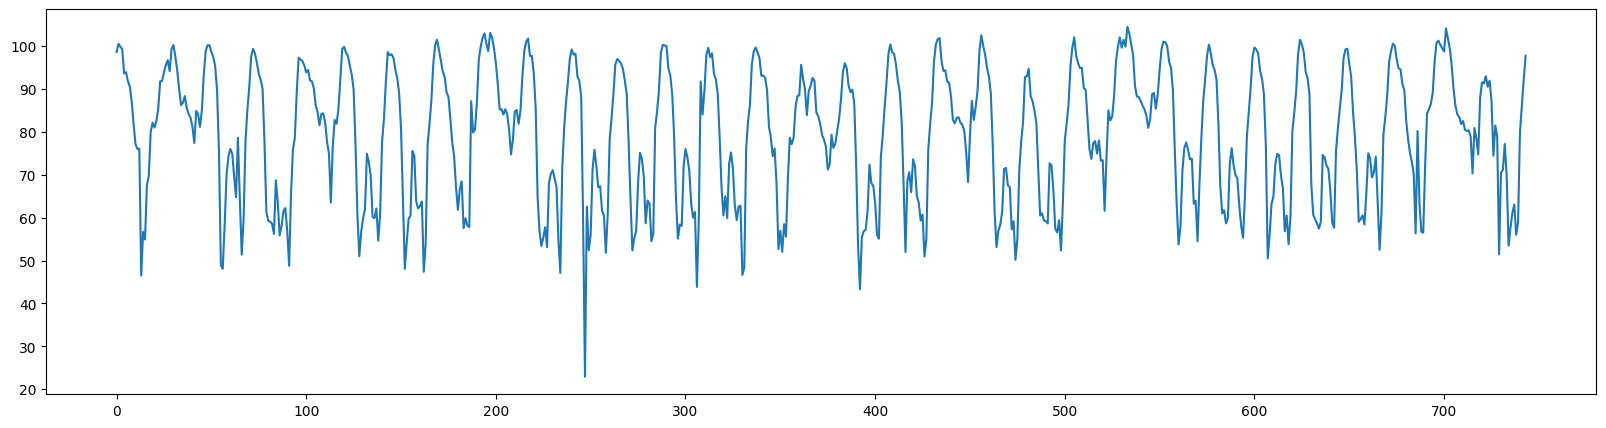

,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


In [34]:
data = pd.read_csv("서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(data["평균속도"])
plt.show()
data.head()


In [35]:
data["date"] = data["집계일시"]
data["date"] = data["date"].astype(str)
data["date"] = pd.to_datetime(data["date"].str.slice(start=0, stop=4) + "/" + data["date"].str.slice(start=4, stop=6) + "/" +data["date"].str.slice(start=6, stop=8) + "/" + data["date"].str.slice(start=8, stop=10) + ":0")
data["value"] = data["평균속도"]

min_max_scaler = MinMaxScaler()
data["value"] = min_max_scaler.fit_transform(data["value"].to_numpy().reshape(-1,1)).reshape(-1)
data = data[["date", "value"]]

data_train = data.iloc[:-24*7].copy()
data.head()

,date,value
0,2021-05-01 00:00:00,0.927845
1,2021-05-01 01:00:00,0.951121
2,2021-05-01 02:00:00,0.942913
3,2021-05-01 03:00:00,0.936543
4,2021-05-01 04:00:00,0.866716


In [36]:
pred_len = 24*7

seq_len = pred_len#인풋 크기
label_len = pred_len#디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True



dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

/var/folders/lm/jrq9cqf106x2mzz5t8vg7_pr0000gn/T/ipykernel_9403/1323133032.py:22: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/lm/jrq9cqf106x2mzz5t8vg7_pr0000gn/T/ipykernel_9403/1323133032.py:23: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/lm/jrq9cqf106x2mzz5t8vg7_pr0000gn/T/ipykernel_9403/1323133032.py:24: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
/var/folders/lm/jrq9cqf106x2mzz5t8vg7_

In [37]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("mps")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
train_epochs = 100
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))

loss: 0.499192:   5%|▌         | 5/100 [00:29<09:12,  5.81s/it]


KeyboardInterrupt: 

In [39]:
import time
now = time.time()
scaler = dataset.scaler
df_test = data_train.copy()
df_test["value"] = scaler.transform(df_test["value"])
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"][1] - df_test["date"][0]
for i in range(pred_len):
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
df_test = df_test.fillna(0)


df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []

with torch.no_grad():
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds
print(time.time() - now)

AttributeError: 'DataFrame' object has no attribute 'append'

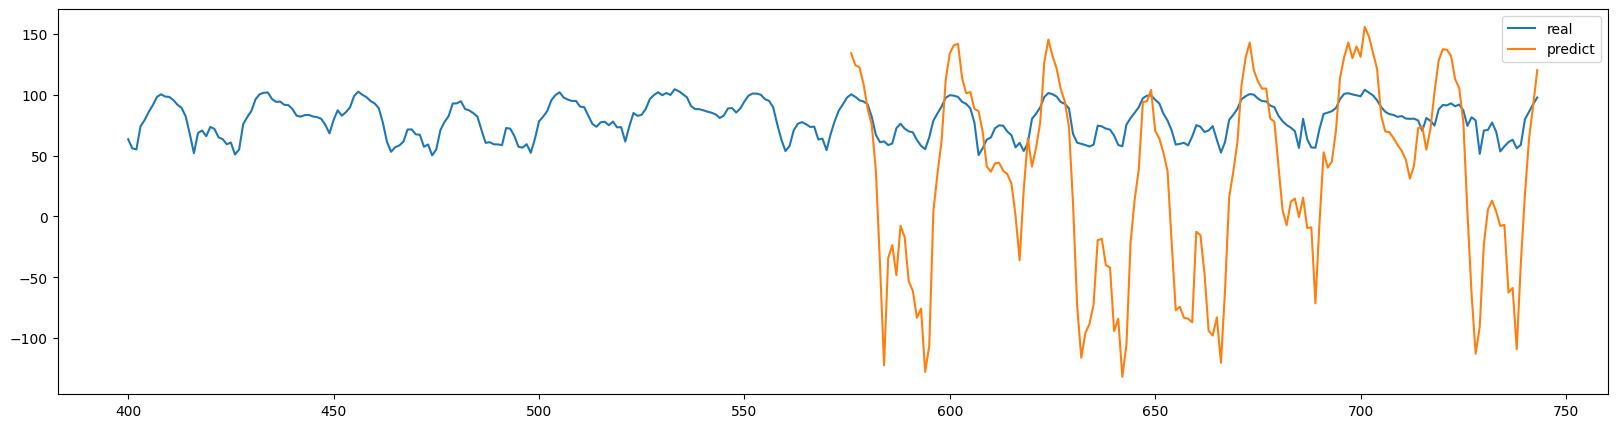

In [40]:
import matplotlib.pyplot as plt

real = data["value"].to_numpy()
result = df_test["value"].iloc[-24*7:].to_numpy()

real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
result = min_max_scaler.inverse_transform(result.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(20,5))
plt.plot(range(400,744),real[400:], label="real")
plt.plot(range(744-24*7,744),result, label="predict")
plt.legend()
plt.show()

In [41]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-24*7:])

91.90072783436555